# マイクロマウスのモデリング

マイクロマウスの動きをシミュレーションするために，まずはどのようなダイナミクスにしたがって運動するかを数式で記述する必要があります．  
マイクロマウスの場合，回路を流れる電流によってモーターにトルクが発生し，タイヤと地面との摩擦力によって並進方向の力が生じるので，  
運動方程式と回路方程式を中心に式を組み立てていくといいでしょう．

![](img/motor_circuit_01.png)



In [1]:
# -*- coding: utf-8 -*-
from sympy import *
from IPython.core.display import display
init_printing()

VMR, IR, dphiR = symbols('V_MR I_R \dot{\phi}_R')
VML, IL, dphiL = symbols('V_ML I_L \dot{\phi}_L')
R, KE = symbols('R K_E')
eq1_R = Eq(VMR, R*IR + KE*dphiR)
eq1_L = Eq(VML, R*IL + KE*dphiL)

print('<モーターの回路方程式>')
IR = solve(eq1_R, IR)[0]
IL = solve(eq1_L, IL)[0]
# eq1_L = Eq(IL, solve(eq1_L, IL)[0])

display(Eq(symbols('I_R'), IR))
display(Eq(symbols('I_L'), IL))

<モーターの回路方程式>


In [2]:
tau_R, tau_L = symbols('tau_R tau_L')
KT = symbols('K_T')
print('\n<電流-トルクの関係式>')
display(Eq(tau_R, var('K_T')*var('I_R')))
display(Eq(tau_L, var('K_T')*var('I_L')))

print('\n<電圧-トルクの関係式>')
tau_R = KT*IR
tau_L = KT*IL
display(Eq(symbols('tau_R'),tau_R));
display(Eq(symbols('tau_L'),tau_L));


<電流-トルクの関係式>



<電圧-トルクの関係式>


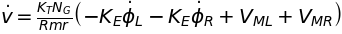

In [3]:
m, v, x, dotv, dotx = symbols('m v x \dot{v} \dot{x}')
FR, FL  = symbols('F_R F_L')
r, Ng = symbols('r N_{G}')
FR = Ng*tau_R/r
FL = Ng*tau_L/r

eq3_v = Eq(dotv, (FR+FL)/m); 
eq3_x = Eq(v, dphiR*r/Ng+dphiL*r/Ng );
# eq3_vx = Eq(dotx, v)

display(simplify(eq3_v), eq3_x)

ここで式を簡単にするために，
$$ \dot{\phi}:= \dot{\phi}_R + \dot{\phi}_L $$
$$ V_m := V_R + V_L$$
と定義する．すると，

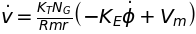

In [4]:
# TODO: 等式に代入することはできる？
phi, dphi, Vm = var('\phi \dot{\phi} V_m')

eq4_x = Eq(dotx, v)
eq4_v = Eq(dotv, (KT*Ng)/(R*m*r)*(-KE*dphi+ Vm))
eq4_phi = Eq(v, dphi*r/Ng)

display(eq4_x,eq4_v, eq4_phi)

となることが分かりました．この式を $\dot{x},\dot{v},\dot{phi}$について整理してみます．すると次のような関係式が得られます．

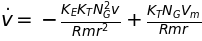

In [5]:
sols = solve([eq4_v, eq4_phi, eq4_x], [dotv, dphi, dotx])

eq_sol_v = Eq(dotv, sols[dotv])
eq_sol_phi = Eq(dphi, sols[dphi])
eq_sol_x = Eq(dotx, sols[dotx])

display(eq_sol_x, expand(eq_sol_v),eq_sol_phi)

この式で一番重要なのは，2番目の式です．  
この式から，DCモーターによって駆動するマイクロマウスの速度-加速度の関係は，一次の運動方程式で表現され，
加速度$\dot{v}$は現在の速度$v$とモータに入力する電圧$Vm$で決定されることが分かります．
また，速度$v$にかかる係数の符号は負であるため，速度と加速度の間にはトレードオフの関係があることが分かります．

シミュレーションをする上で，上式をそのまま使っても数値計算はできますが，**「状態方程式(StateSpace)」**形式に形を少し変えると，
多入力多出力システムの表現しやすいほか，既存のライブラリで計算がしやすくなります．

状態方程式は，状態変数$X=[x_1, x_2,...,x_n]^T$および出力変数$Y=[y_1, y_2,...,y_m]^T$ に対して，次のような係数行列$A,B,C$を含んだ形式で表される方程式です．(対象によっては，2番目の式を$Y=CX + Du$とする場合もあります)

\begin{eqnarray}
    \dot{X} &=& AX + Bu \\
    Y &=& CX
\end{eqnarray}

今回の直進モデルにおいては，状態変数は$X=[x, v, \phi]^T$ となります．$Y$は実際にセンサーなどによって観測できる変数を指します．  
状態変数Xはロータリエンコーダや加速度センサなどを用いて，（間接的に）計測することが可能なので，ここでは簡単のため，
$I_3 (\mathbb{R}^{3\times3})$の単位行列を用いて

$$C=I_3$$

$$Y=I_3X = X$$

とすることにしましょう．

>#### ※補足
ここでは，簡単のため$C=I_3$と置いてしまいましたが，現実にはセンサの精度やノイズなどにより正確に計測ができない場合もあります．
例えば，速度$v$を求めるならエンコーダの値を微分するのが簡単ですが，ノイズの乗った値を微分すると速度一定にもかかわらず波形がギザギザになってしまうことがあります．（特に磁気式エンコーダ）  
こういった場合，ノイズは高周波成分を多く含むため，単純に出力値に**ローパスフィルタ**を掛けるか，もしくは
モデルと入出力情報から統計的に状態変数を推定する**「カルマンフィルタ」**などの最尤推定オブザーバを用いることで対処可能です．

>参考: [状態フィードバックと状態変数観測器](http://www.mech.tohoku-gakuin.ac.jp/rde/contents/course/controlII/statefeedback.html)


In [6]:
polv = Poly(sols[dotv], v)
polvm = Poly(sols[dotv], Vm)
polp = Poly(sols[dphi], v)

a = polv.coeffs()[0] # polvの0番目の係数
b = polvm.coeffs()[0] # polvの1番目の係数
c = polp.coeffs()[0] # polpの0番目の係数

A = Matrix([ [0,1,0], [0,a,0], [0,c,0]])
B = Matrix([0, b, 0])
X = Matrix([x, v, phi])
dX = Matrix([dotx, dotv, dphi])

print('<DCマウスの直進モデル>')
Eq(dX, MatAdd(MatMul(A,X), MatMul(B,Vm)))

<DCマウスの直進モデル>


⎡ \dot{x}  ⎤ = ⎡0         1          0⎤⋅⎡ x  ⎤ + ⎡    0    ⎤⋅Vₘ
⎢          ⎥   ⎢                      ⎥ ⎢    ⎥   ⎢         ⎥   
⎢ \dot{v}  ⎥   ⎢                 2    ⎥ ⎢ v  ⎥   ⎢K_T⋅N_{G}⎥   
⎢          ⎥   ⎢   -K_E⋅K_T⋅N_{G}     ⎥ ⎢    ⎥   ⎢─────────⎥   
⎣\dot{\phi}⎦   ⎢0  ────────────────  0⎥ ⎣\phi⎦   ⎢  R⋅m⋅r  ⎥   
               ⎢             2        ⎥          ⎢         ⎥   
               ⎢        R⋅m⋅r         ⎥          ⎣    0    ⎦   
               ⎢                      ⎥                        
               ⎢        N_{G}         ⎥                        
               ⎢0       ─────        0⎥                        
               ⎣          r           ⎦                        

DCマウスの直進モデルは上記の式で与えられることが分かりました．

---

# マイクロマウスの直進モデルに対する速度制御系の設計

状態方程式は 1 階連立型線形微分方程式の形式で表されているので，数値計算をするのは比較的簡単です．  
計算法にはいくつか種類がありますが，ここではPythonのcontrolライブラリを使ってみます．

依存するライブラリがあるので，`control`と`slycot`をインストールしておいてください．
pipが入っていれば，端末を開いて

    sudo pip install control
    sudo pip install slycot
    
とコマンドを打てば，あとは自動でインストールできます．

状態方程式モデルの応答を数値計算する際は，python-controlのStateSpaceクラスを使うと簡単です．numpyのarrayクラスを使って係数行列
$A,B,C=I_3,(D=0)$を作成し，StateSpace(A,B,C,D)のように引数を与えることで状態方程式モデルを作成できます．

一定値入力 $u(t)=1,t >0$ は制御工学の分野で**ステップ入力**と呼ばれます(波形が段差:stepのように見える)．  
このようなステップ入力を与えたときの応答を調べるといった操作はよく行われるので，python-controlにも
専用の関数(`control.matlab.step`)が用意されています．

In [7]:
from control import *
import numpy as np
from matplotlib import pylab as plt
import matplotlib 
%matplotlib inline
plt.rcParams["font.size"] = 13

from __future__ import print_function
from ipywidgets import interact, FloatSlider, RadioButtons

# スライドバーで動かせるプロットを作成
@interact(gear_ratio=(1.0, 10, 0.1), motor_duty=(0, 1.0, 0.01), mass_gram=(5, 200, 0.5))
def sim_trans_system(gear_ratio=3.0, motor_duty=0.5, mass_gram=30):
    Ng = gear_ratio; # ギアの減速比(モーター：ホイール=1:n)
    m = mass_gram/1000; # 機体の質量[kg] (スライドバーからはgで渡される)
    
    # パラメータの設定
    # 回路定数 (MK06-4.5の場合)
    R = 5.0; # ohm
    KE = 7.1504e-04; # 逆起電力定数[V/(rad/s)]
    KT = 6.5e-04; # トルク定数[Nm/I]
    Vbat = 4.0; # モータドライバの電源電圧[V]

    # 機体パラメータ
#     Ng = 3.0;          # ギアの減速比(モーター：ホイール=1:n), スライドバーで設定
    r = 7.5e-03;    # タイヤ半径[m]
#     m = 75e-03;     # 機体重量[kg], スライドバーで設定
    w = 30e-03;     # 機体の中心から右端までの距離(横幅/2) [m]
    h = 45e-03;     # 機体の中心から先端までの距離(縦幅/2) [m]
    # J = 1/3*(w**2+h**2)*m; # 機体の慣性モーメント(形状を長方形に近似)

    
    # 状態空間形式(dX/dt = AX + Bu, y = Cx)でシステムを表現    
    a = -(KT*KE*Ng**2)/(R*m*r**2)
    b = (2*motor_duty*Vbat) * (KT*Ng)/(m*r*R) # Vm = (2*motor_duty*Vbat)*u と置いた
    c = 1/(Ng*r)
    A = np.array([ [0,1,0], [0,a,0], [0,c,0]]) 
    B = np.array([[0], [b], [0]])
    C = np.array([[1,0,0],[0,1,0],[0,0,1]])
    D = np.array([[0],[0],[0]])
    sys = StateSpace(A, B, C, D)

    # 線形シミュレーション:ステップ入力 u(t)=1 (t>0)
    t = np.linspace(0, 20, 1000)
    yout, T = matlab.step(sys, t) 
    v_array = yout[:,1]
    dphi_array = v_array*c
    I_array = 2*(-KE*dphi_array+(motor_duty*Vbat))/R

    # シミュレーション結果のプロット
    fig, (axL, axR) = plt.subplots(ncols=2, figsize=(16,6))
    axL.plot(T, v_array)
    axL.axhline(b/-a, color="b", linestyle="--");
    axL.set_xlim(0, 20);  axL.set_ylim(0,25);
    axL.set_xlabel('time t[s]');axL.set_ylabel('speed vx [m/s]')
    axL.set_title('  Forward Speed (Vm: Step Input)');  # 日本語使えないつらい
        
    axR.plot(T, I_array)
    axR.set_xlim(0, 20);
    axR.set_xlabel('time t[s]');axR.set_ylabel('current I_total [A]')

    axR.set_title('Total Current of 2 Motors [A]');  # 日本語使えないつらい
    
    plt.show();


In [8]:
class MouseConfig:
    def __init__(self):
        self.R = 5.0; # 抵抗 [ohm]
        self.KE = 7.1504e-04; # 逆起電力定数[V/(rad/s)]
        self.KT = 6.5e-04; # トルク定数[Nm/I]
        self.Vbat = 4.0; # モータドライバの電源電圧[V]

        # 機体パラメータ
        self.Ng = 3.0;          # ギアの減速比(モーター：ホイール=1:n), スライドバーで設定
        self.r = 7.5e-03;    # タイヤ半径[m]
        self.m = 75e-03;     # 機体重量[kg], スライドバーで設定
        self.w = 30e-03;     # 機体の中心から右端までの距離(横幅/2) [m]
        self.h = 45e-03;     # 機体の中心から先端までの距離(縦幅/2) [m]
        self.J = 1/3*(self.w**2+self.h**2)*self.m; # 機体の慣性モーメント(形状を長方形に近似)


class MouseDynamics:
    """
    Body and Motor Model (Transrational)
    -
    Input: 
        * duty :Duty ratio of the voltage input to the motor
    Output:
        * x: Position
        * v: Speed (Forward +)
        * phi: motor rotation [in radian]
        
    """
    
    def __init__(self, config=-1):  # コンストラクタ
        if config == -1:
            # 回路定数 (MK06-4.5の場合)
            self.R = 5.0; # ohm
            self.KE = 7.1504e-04; # 逆起電力定数[V/(rad/s)]
            self.KT = 6.5e-04; # トルク定数[Nm/I]
            self.Vbat = 4.0; # モータドライバの電源電圧[V]

            # 機体パラメータ
            self.Ng = 3.0;          # ギアの減速比(モーター：ホイール=1:n), スライドバーで設定
            self.r = 7.5e-03;    # タイヤ半径[m]
            self.m = 75e-03;     # 機体重量[kg], スライドバーで設定
            self.w = 30e-03;     # 機体の中心から右端までの距離(横幅/2) [m]
            self.h = 45e-03;     # 機体の中心から先端までの距離(縦幅/2) [m]
            self.J = 1/3*(self.w**2+self.h**2)*self.m; # 機体の慣性モーメント(形状を長方形に近似)
        else:
            self.R = config.R; # ohm
            self.KE = config.KE; # 逆起電力定数[V/(rad/s)]
            self.KT = config.KT; # トルク定数[Nm/I]
            self.Vbat = config.Vbat; # モータドライバの電源電圧[V]
            self.Ng = config.Ng;          # ギアの減速比(モーター：ホイール=1:n), スライドバーで設定
            self.r = config.r;     # タイヤ半径[m]
            self.m = config.m;     # 機体重量[kg], スライドバーで設定
            self.w = config.w;     # 機体の中心から右端までの距離(横幅/2) [m]
            self.h = config.h;     # 機体の中心から先端までの距離(縦幅/2) [m]
            self.J = config.J;     # 機体の慣性モーメント(形状を長方形に近似)        

        self._ismodified = False # モデル再計算フラグ
        # state space model
        a = -(self.KT*self.KE*self.Ng**2)/(self.R*self.m*self.r**2)
        b = (2*self.Vbat) * (self.KT*self.Ng)/(self.m*self.r*self.R) # Vm = (2*motor_duty*Vbat)*u と置いた
        c = 1/(self.Ng*self.r)
        A = np.array([ [0,1,0], [0,a,0], [0,c,0]]) 
        B = np.array([[0], [b], [0]])
        C = np.array([[1,0,0],[0,1,0],[0,0,1]])
        D = np.array([[0],[0],[0]])
        self.sys = StateSpace(A, B, C, D)
        
    def set_config(config):
        self.R = config.R; # ohm
        self.KE = config.KE; # 逆起電力定数[V/(rad/s)]
        self.KT = config.KT; # トルク定数[Nm/I]
        self.Vbat = config.Vbat; # モータドライバの電源電圧[V]
        self.Ng = config.Ng;          # ギアの減速比(モーター：ホイール=1:n), スライドバーで設定
        self.r = config.r;     # タイヤ半径[m]
        self.m = config.m;     # 機体重量[kg], スライドバーで設定
        self.w = config.w;     # 機体の中心から右端までの距離(横幅/2) [m]
        self.h = config.h;     # 機体の中心から先端までの距離(縦幅/2) [m]
        self.J = config.J;     # 機体の慣性モーメント(形状を長方形に近似)        
        self._ismodified = True
        
    @property
    def ss(self):
        if self._ismodified: # パラメータに変更があればモデルを再計算
            # state space model
            a = -(self.KT*self.KE*self.Ng**2)/(self.R*self.m*self.r**2)
            b = (2*self.Vbat) * (self.KT*self.Ng)/(self.m*self.r*self.R) # Vm = (2*Vbat)*u と置いた
            c = 1/(self.Ng*self.r)
            A = np.array([ [0,1,0], [0,a,0], [0,c,0]]) 
            B = np.array([[0], [b], [0]])
            C = np.array([[1,0,0],[0,1,0],[0,0,1]])
            D = np.array([[0],[0],[0]])
            self.sys = StateSpace(A, B, C, D)
            self._ismodified = False

        return self.sys

    

In [9]:
config = MouseConfig()

config.R = 5.0; # 抵抗 [ohm]
config.KE = 7.1504e-04; # 逆起電力定数[V/(rad/s)]
config.KT = 6.5e-04; # トルク定数[Nm/I]
config.Vbat = 4.0; # モータドライバの電源電圧[V]
config.Ng = 3.0;          # ギアの減速比(モーター：ホイール=1:n), スライドバーで設定
config.r = 7.5e-03;    # タイヤ半径[m]
config.m = 50e-03;     # 機体重量[kg], スライドバーで設定
config.w = 30e-03;     # 機体の中心から右端までの距離(横幅/2) [m]
config.h = 45e-03;     # 機体の中心から先端までの距離(縦幅/2) [m]
config.J = 1/3*(config.w**2+config.h**2)*config.m; # 機体の慣性モーメント(形状を長方形に近似)
mouse = MouseDynamics(config)


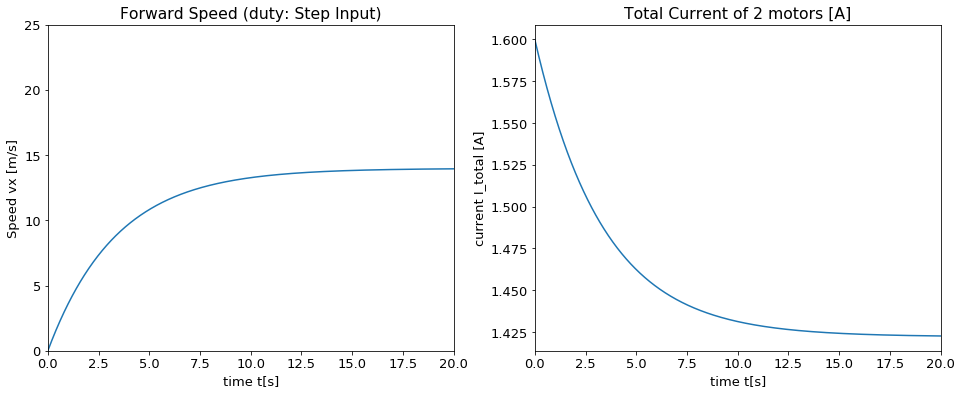

In [10]:
# 線形シミュレーションの実行
motor_duty = 0.5
t = np.linspace(0, 20, 1000)
u = np.ones(1000) * motor_duty # u(t)=duty (const)
yout, T, xout = matlab.lsim(mouse.ss, u, t)
v_array = xout[:,1]
c = mouse.ss.A[2,1]
dphi_array = v_array*c
I_array = 2*(-config.KE*dphi_array+(config.Vbat))/config.R  # 回路方程式から計算

# シミュレーション結果のプロット
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(16,6))

axL.plot(T, v_array)
axL.set_xlim(0, 20);  axL.set_ylim(0,25);
axL.set_xlabel('time t[s]'); axL.set_ylabel('Speed vx [m/s]')
axL.set_title('Forward Speed (duty: Step Input)');  
# axL.tick_params(labelsize=13)

axR.plot(T, I_array)
axR.set_xlim(0, 20);
axR.set_xlabel('time t[s]');axR.set_ylabel('current I_total [A]')
axR.set_title('Total Current of 2 motors [A]');  
# axR.tick_params(labelsize=13)

plt.show();

それでは直進走行モデルを用いて速度の制御系を立ててみます．  
まずは，第一ステップとして，ステップ入力で目標速度値が与えられたとき，速度が$t\to \infty$で偏差なく追従することを目指してみましょう．

以下に示すのは，一番ベーシックなフィードバック制御系のブロック線図です．
Pは制御対象でプラントと呼ばれることもあります．今回の例では，入力がdutyで出力が速度なシステムだと考えてください．  
Kはコントローラを表します．基準速度$v_{ref}$と実際の出力$v$との偏差$e$を入力し，内部で何らかの演算を行うことで制御対象へ与える入力値$u$を決定します．  
$K$のとり方は自由ですが，今回はメジャーな制御法の一つであるPID制御器を設計してみましょう．

<img src="img/FeedbackSpeedControl.PNG" width=70%>


PID制御器は時間領域では，
$$
    K(t) = K_p e(t)  + K_i \int_0^t e(t)dt + K_d \dfrac{de(t)}{dt}
$$

ラプラス変換形式(伝達関数形式)では，

$$
    K(s) = K_p E(s)  + K_i \dfrac{1}{s} E(s) + K_d sE(s) \\
        = ( \dfrac{K_d s^2 + K_p s +  K_i}{s})E(s)
$$

と表すことができます．両者の式は等価なので，どちらを使っても同じ結果になりますが，
ラプラス変換の方がブロック線図と相性がよく考えやすいのでこちらを使います．  
python-controlでは，連立微分方程式で表現された状態方程式とラプラス変換で表現された伝達関数が混在していても，
自動で計算に都合の良い形式にモデルを変換してくれます．

---

それでは，ステップ入力で与えられた目標速度にうまく追従するようにPIDのパラメータを調整してみましょう．
ただし，モーターへ与えることのできるdutyは最大100％であるので，これを超えないようにしましょう．
（オーバーすると，プロットが赤色になります）


In [11]:
# ステップ目標値を与えたときの，FB制御系のシミュレーション
@interact(Kp=(0.01, 3, 0.01), Ki=(0, 5, 0.001), Kd=(0, 5, 0.01), target=(0,3,0.1))
def sim_closed_loop(Kp=1.0, Ki=0, Kd=0, target=1):
    # PID 制御器 の作成

#     num = [Kd, Kp, Ki]
#     den = [1, 0]
#     K = matlab.tf(num, den)
    
    # PIDコントローラ（伝達関数形式）の作成
    # 純粋微分器は計算不可能なので，1次ローパスフィルタを接続した実用微分器(Kd*s/(gamma*Kd*s+1))を使う
    D_COEFFICIENT = 0.1 # 微分係数
    Kp = matlab.tf([Kp], [1])
    Ki = matlab.tf([Ki], [1, 0])
    Kd = matlab.tf([Kd, 0], [D_COEFFICIENT*Kd, 1])  
    K = Kp+Ki+Kd

    dmux = StateSpace(0,np.array([0,0,0]),0,np.array([0,1,0]) )
    P = series(mouse.ss , dmux) # 3出力あるうちの2番目(v)だけを取り出す． 

    # 閉ループ系の伝達関数を計算
    Ysys = matlab.feedback(K*P, 1, -1)  # ネガティブフィードバック
    Esys = matlab.feedback(1, K*P, -1)
    Usys = K/(1+K*P)
    
    # 線形シミュレーション
    SIM_TIME = 5    # シミュレーション時間
    SAMPLE_RATE = 100 # サンプリングレート
    t = np.linspace(0, SIM_TIME, SIM_TIME*SAMPLE_RATE)
    ref = np.ones(SIM_TIME*SAMPLE_RATE) * target # u(t)=duty (const)
    yout, T, xout = matlab.lsim(Ysys, ref, t)
#     Eout, T, xout = matlab.lsim(Esys, ref, t)
    Uout, T, xout = matlab.lsim(Usys, ref, t)
    
    
    
    if np.amax(Uout) > 1.0 :
        _is_saturated = True
    else :
        _is_saturated = False
        
    # シミュレーション結果のプロット
    fig, (axL, axR) = plt.subplots(ncols=2, figsize=(16,6))
    
    axL.plot(T, yout)
    axL.axhline(target, color="k", linestyle="--");
    axL.set_xlim(0, SIM_TIME);  axL.set_ylim(0,5);
    axL.set_xlabel('time t [s]'); axL.set_ylabel('Speed vx [m/s]')
    axL.set_title('Speed Control');  
    # axL.tick_params(labelsize=13)

    if _is_saturated: axR.plot(T, Uout, 'r',  lw=5)
    else: axR.plot(T, Uout, 'b')
    axR.set_xlim(0, SIM_TIME);
    axR.set_xlabel('time t [s]');axR.set_ylabel('duty [.]')
    axR.set_title('Average Duty Output To Two Motors');  
    # axR.tick_params(labelsize=13)

    plt.show();


目標速度$v_{target}$と$Kp,Ki,Kd$のスライダーを動かして，いろいろ試してみましょう．


---

どうだったでしょうか？  
今回の問題設定では，$t\to \infty$で漸近安定にするためにはP制御があれば十分であり，もし定常偏差も0にしたいなら$Ki$を増やせば良いことがわかります．  

筆者の設定したパラメータでは，$v_{target}=1.0 $[m/s]のとき，$Kp=0.84, Ki=0.08$で入力dutyに20%ほどの余裕を残すことができました．


![@aaa](img/control_result01.PNG)


低速度で走行する場合には，これで十分でしょう．(1m/sでも結構早いですが)  
しかし，ここはコンマ一秒を争うマイクロマウスの世界，どうせならできるだけ高速かつ高加速度を追求したいものです．

そういったことを考えると実は，先程の制御系はいくつかの問題点を抱えています．その問題点とは，以下のようなものです．

* ステップ入力の目標値はそもそも実現不可能(これを実現しようとすると，加速度$a\to \infty$となるため)
* 急加速を行うことになるため，場合によってはタイヤのスリップと言った影響が無視できなくなる．
* また，急加速に伴い動作開始時に非常に大きな電流が流れるため，設計次第ではモーター回路が焼かれて死ぬ．
* 入力値は最初の一瞬だけ高くて，後は低いという，無駄が多い制御となっている．
* 目標速度を上げると，PIDパラメータの再調整が必要

このような問題を克服するため，目標速度を一定値で与えるのではなく，加速→等速→減速といった台形加速の目標値信号を与えることを考えます．
ただし，モータの特性上，速度と加速度にはトレードオフの関係があるので，まずは目標とする最高速度に対して実現可能な加速度を
見積もっておきます．

マウス直進モデルを求める際に，機体の速度$v$と加速度$\dot{v}$の間には次のような関係があったことを思い出してみます．

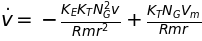

In [12]:
display(expand(eq_sol_v))

台形加速による等加速度制御を行うためには，最高速に達するまで同じ加速度を維持できなければいけません．
直進の制御だけでなく，回転の制御も後で行うことを考えると，コントローラの出力には余裕をもたせたいので，
最高速時，$V_m = 2V_{Bat}\times 0.8$となっているようにします．

すると，

$$\dot{v} = \alpha v_{Goal} + \beta Vm$$ とおくと，

$$a_{max} = \alpha v_{Goal} + 1.6 \beta V_{Bat}$$

$$(ただし，\alpha= -\frac{K_{E} K_{T} N_{G}^{2} }{R m r^{2}},\  \beta =\frac{K_{T} N_{G} }{R m r})$$

となるので，目標速度の傾きは$a_{max}$より低くなければならないことがわかりました．  

例として，最高速度を$v_{Goal}=2.0$ [m/s] に設定した場合，

In [13]:
a = mouse.ss.A[1,1]
b = mouse.ss.B[1,0] 
v_bat = 3.6 # 1セル Lipo
v_goal = 2.0 # 最高速度

a_max = a*v_goal + 0.8*b #*2*v_bat
print("a_max: {0:.3f} [m/s^2], v_goal: {1:.3f} [m/s]".format(a_max, v_goal))
print("最高速度に達するまでに {0:.3f}秒".format(v_goal/a_max))

a_max: 6.061 [m/s^2], v_goal: 2.000 [m/s]
最高速度に達するまでに 0.330秒


となるので，$a_{max}=6.061 [m/s^2]$が限界のようです．

このように，加速度と最高速度は独立には設定できないので，先に一方を決めてしまった後に，
もう一方を実現可能な解の中から選ぶようにしたほうがトラブルが少ないでしょう．

下の例では，目標速度$v_{GOAL}$から算出した限界加速度$a_{max}$に0〜1のゲイン(acc_gain)を掛けることで，
目標軌道を決定しています．

>```python
# 限界加速度を計算
a_max = a*v_goal + 0.8*b 
acc_ref = a_max * acc_gain/100
```


In [14]:
a = mouse.ss.A[1,1]
b = mouse.ss.B[1,0] 

# 台形加速軌道を与えたときの，FB制御系のシミュレーション
@interact(Kp=(0.01, 10, 0.01), Ki=(0, 5, 0.001), Kd=(0, 5, 0.01), v_goal=(0,4,0.1), acc_gain=(0,100,0.1))
def sim_closed_loop(Kp=1.0, Ki=0, Kd=0, v_goal=1, acc_gain=100):
    # PID 制御器 の作成

    # 限界加速度を計算
    a_max = a*v_goal + 0.8*b 
    acc_ref = a_max * acc_gain/100
    
    # PIDコントローラ（伝達関数形式）の作成
    # 純粋微分器は計算不可能なので，1次ローパスフィルタを接続した実用微分器(Kd*s/(gamma*Kd*s+1))を使う
    D_COEFFICIENT = 0.1 # 微分係数
    Kp = matlab.tf([Kp], [1])
    Ki = matlab.tf([Ki], [1, 0])
    Kd = matlab.tf([Kd, 0], [D_COEFFICIENT*Kd, 1])  
    K = Kp+Ki+Kd
#     K =matlab.c2d(K, 0.001)

    dmux = StateSpace(0,np.array([0,0,0]),0,np.array([0,1,0]) )
    P = series(mouse.ss , dmux) # 3出力あるうちの2番目(v)だけを取り出す． 

    # 閉ループ系の伝達関数を計算
    Ysys = matlab.feedback(K*P, 1, -1)  # ネガティブフィードバック
    Esys = matlab.feedback(1, K*P, -1)
    Usys = K/(1+K*P)
    
    # 線形シミュレーション
    SIM_TIME = 3    # シミュレーション時間
    SAMPLE_RATE = 1000 # サンプリングレート
    
    t = np.linspace(0, SIM_TIME, SIM_TIME*SAMPLE_RATE)
    ref = acc_ref*t
    ref[ref>v_goal] = v_goal
    yout, T, xout = matlab.lsim(Ysys, ref, t)
    #     Eout, T, xout = matlab.lsim(Esys, ref, t)
    Uout, T, xout = matlab.lsim(Usys, ref, t)

    
    if np.amax(Uout) > 1.0 :
        _is_saturated = True
    else :
        _is_saturated = False
        
    # シミュレーション結果のプロット
    fig, (axL, axR) = plt.subplots(ncols=2, figsize=(16,6))
    
    axL.plot(t, yout)
    axL.plot(t, ref)    
    axL.set_xlim(0, SIM_TIME);  axL.set_ylim(0,5);
    axL.set_xlabel('time t [s]'); axL.set_ylabel('Speed vx [m/s]')
    axL.set_title('Speed Control');  
    # axL.tick_params(labelsize=13)

    if _is_saturated: axR.plot(T, Uout, 'r',  lw=5)
    else: axR.plot(T, Uout, 'b')
    axR.set_xlim(0, SIM_TIME);
    axR.set_xlabel('time t [s]');axR.set_ylabel('duty [.]')
    axR.set_title('Average Duty Output To Two Motors');  
    # axR.tick_params(labelsize=13)

    plt.show();


どうでしょうか？先程よりも調整が楽になったことが分かるでしょうか？

先程のステップ指令値の場合には，目標速度を変更したらPIDパラメータの再調整が必要でしたが，  
こちらの台形加速の場合は一旦PIDのパラメータを決めてしまえば，目標速度が変わっても同じような制御性能を発揮してくれます．  
また，実現可能な加速度・最高速度の軌道を設定したお陰で，常に出力が80%以内に収まっていることが確認できます．

指定した目標値に追従するように制御する制御系のことを**サーボ(Servo)系**と呼ぶのですが，  
このサーボ系の制御問題においては「どのような目標軌道」を与えるかという点も制御性能に関わる非常に重要な要素であることがわかります．

---

ところで，これまで，

TODO:感度関数と相補感度関数
追従性能とノイズ低減性能